# MODEL GRIDS WITH PYCLOUDY

## Global budget

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyCloudy as pc
pc.config.cloudy_exe = 'cloudy.exe'
models_dir = './Models/'

### Construct a series of plane-parallel models of density n = 100 cm$^{-3}$ ionized by a blackbody at 50,000 K, varying log U between -3.5 and -1.5 by steps of 0.5 dex and the metallicity as 12 + log O/H from 7 to 9 by steps of 0.5 dex (take He/H =0.1 for all the models and adopt the solar abundance ratios from Asplund et al. (2009) for all the heavy elements).

##### We define some function to prepare and run the grid of Cloudy models.

In [2]:
options = ('no molecules',
           'no level2 lines',
           'no fine opacities',
           'atom h-like levels small',
           'atom he-like levels small',
           'element limit off -7',
            )
from pyCloudy.utils.physics import abund_Asplund_2009

def get_R_in_Q0(logU, fr, NH=100, ff=1.0):
    c = pc.CST.CLIGHT
    U_mean = 10**logU
    w = (1 + fr**3.)**(1./3) - fr
    alpha_B = 2.6e-13
    Q0 = 4. * np.pi * c**3 * U_mean**3 / (3. * NH * ff**2 * alpha_B**2 * w**3)
    R_str = (3. * Q0 / (4 * np.pi * NH**2 * alpha_B * ff))**(1./3)
    R_in = fr * R_str
    return R_in, Q0

def make_mod(name, logU, ab_O):
    NH = 100
    ff = 0.1
    fr = 10.00
    R_in, Q0 = get_R_in_Q0(logU, fr=fr, NH=NH, ff=ff)
    c_input = pc.CloudyInput('{0}/{1}'.format(models_dir, name))
    c_input.set_BB(Teff = 50000., lumi_unit = 'q(H)', lumi_value = np.log10(Q0))
    c_input.set_cste_density(np.log10(NH), ff = ff)
    c_input.set_radius(r_in = np.log10(R_in))
    abund = abund_Asplund_2009.copy()
    delta_O = ab_O - 12 - abund['O']
    for elem in abund:
        if elem != 'He':
            abund[elem] += delta_O
    c_input.set_abund(ab_dict = abund)
    c_input.set_grains('Orion {}'.format(10**delta_O))
    c_input.set_distance(dist=1., unit='kpc', linear=True)
    c_input.set_other(options)
    c_input.set_stop(('temperature off', 'pfrac 0.02'))
    c_input.print_input()

In [3]:
generic_name = 'M7_'

##### We prepare the models

In [4]:
for logU in np.arange(-3.5, -1.49, 0.5):
    for ab_O in np.arange(7, 9.1, 0.5):
        name = '{}{:.1f}_{:.1f}'.format(generic_name, logU, ab_O)
        make_mod(name, logU, ab_O)

##### We run the models.

In [5]:
pc.run_cloudy(dir_=models_dir, n_proc=8, model_name=generic_name)

##### We read the models in a list.

In [6]:
Ms = pc.load_models('{}/{}'.format(models_dir, generic_name),
                    read_emis = False)

##### We verify that the Hbeta flux is available from the CloudyModel object.

In [7]:
print(np.float(pc.sextract(Ms[0].out['Hbeta'], 'H  1      4861.36A', '1.000').strip()))

41.794


In [11]:
pc.sextract??

In [12]:
! ls ./Models/M7_*

./Models/M7_-1.5_7.0.cont    ./Models/M7_-2.5_8.0.ele_Si
./Models/M7_-1.5_7.0.cool    ./Models/M7_-2.5_8.0.gabund
./Models/M7_-1.5_7.0.ele_Ar  ./Models/M7_-2.5_8.0.gdgrat
./Models/M7_-1.5_7.0.ele_C   ./Models/M7_-2.5_8.0.gtemp
./Models/M7_-1.5_7.0.ele_Cl  ./Models/M7_-2.5_8.0.heat
./Models/M7_-1.5_7.0.ele_Fe  ./Models/M7_-2.5_8.0.in
./Models/M7_-1.5_7.0.ele_H   ./Models/M7_-2.5_8.0.opd
./Models/M7_-1.5_7.0.ele_He  ./Models/M7_-2.5_8.0.out
./Models/M7_-1.5_7.0.ele_N   ./Models/M7_-2.5_8.0.ovr
./Models/M7_-1.5_7.0.ele_Ne  ./Models/M7_-2.5_8.0.phy
./Models/M7_-1.5_7.0.ele_O   ./Models/M7_-2.5_8.0.rad
./Models/M7_-1.5_7.0.ele_S   ./Models/M7_-2.5_8.5.cont
./Models/M7_-1.5_7.0.ele_Si  ./Models/M7_-2.5_8.5.cool
./Models/M7_-1.5_7.0.gabund  ./Models/M7_-2.5_8.5.ele_Ar
./Models/M7_-1.5_7.0.gdgrat  ./Models/M7_-2.5_8.5.ele_C
./Models/M7_-1.5_7.0.gtemp   ./Models/M7_-2.5_8.5.ele_Cl
./Models/M7_-1.5_7.0.heat    ./Models/M7_-2.5_8.5.ele_Fe
./Models/M7_-1.5_7.0.in      ./Models/M7_-2.5_8.5.ele_H
./

##### We define the variables to be plotted. They are mainly obtained by looping on the models, using list comprehension technic.

In [15]:
Ms[0].print_stats()

 Name of the model: ./Models/M7_-3.5_7.0
 R_in (cut) = 1.094e+22 (1.094e+22), R_out (cut) = 1.094e+22 (1.094e+22)
 H+ mass = 5.00e+07, H mass = 6.83e+07
 <H+/H> = 0.91, <He++/He> = 0.00, <He+/He> = 0.90
 <O+++/O> = 0.00, <O++/O> = 0.07, <O+/O> = 0.84
 <N+++/O> = 0.00, <N++/O> = 0.13, <N+/O> = 0.81
 T(O+++) = 13040, T(O++) = 12792, T(O+) = 12365
 <ne> = 80,  <nH> = 100, T0 = 12218, t2=0.0062
 <log U> = -3.50


In [16]:
Ms[0].out

{'###First': ' ####  1  Te:1.355E+04 Hden:1.000E+02 Ne:1.068E+02 R:1.094E+22 R-R0:5.516E+14 dR:1.103E+15 NTR:  8 Htot:2.287E-20 T912: 8.87e-04###\n',
 '###Last': ' ####121  Te:7.939E+03 Hden:1.000E+02 Ne:2.364E+00 R:1.094E+22 R-R0:5.384E+18 dR:1.963E+16 NTR:  7 Htot:7.814E-23 T912: 9.14e+01###\n',
 'Blackbody': '                       * Blackbody 50000.000000                                                          *\n',
 'Chem1': '        H :  0.0000  He: -1.0700  C : -5.2600  N : -5.8600  O : -5.0000  Ne: -5.7600  Mg: -6.0900  Si: -6.1800  S : -6.5700\n',
 'Chem2': '                                                            Fe: -6.1900\n',
 'Chem3': ' \n',
 'Chem4': '                                                    Grain Chemical Composition\n',
 'Cloudy ends': ' Cloudy ends: 121 zones, 1 iteration, 2 cautions. (single thread) ExecTime(s) 35.95\n',
 'D/G': ' Dust to gas ratio (by mass): 1.157e-04, A(V)/N(H)(pnt):1.132e-23, (ext):8.193e-24, R:3.676e+00 AV(ext):4.419e-04 (pnt):6.10

In [8]:
x = np.array([M.log_U_mean for M in Ms])
logHb = np.array([np.float(pc.sextract(M.out['Hbeta'], 'H  1      4861.36A', '1.000').strip()) for M in Ms])
logQ = np.log10(np.array([M.Q.sum() for M in Ms]))
y = logHb - logQ
c = 12+np.array([M.abund['O'] for M in Ms])

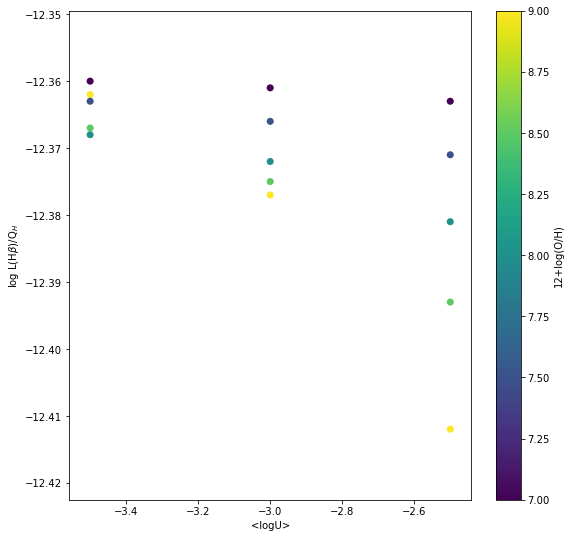

In [9]:
f, ax = plt.subplots(figsize=(9, 9))
sc = ax.scatter(x, y, c=c, edgecolor='none', s=50)
ax.set_xlabel('<logU>')
ax.set_ylabel(r'log L(H$\beta$)/Q$_ H$')
cb = f.colorbar(sc)
cb.set_label(r'12+log(O/H)')

In [10]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()